In [69]:
'''Basic Libraries'''
import pandas as pd 
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt 
import os.path 
import idx2numpy
import regex as re
import warnings 
import math
import itertools
warnings.filterwarnings('ignore')


'''Preprocessing and Modeliing Libraries'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, AveragePooling2D, Input, Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [70]:
#loading the mnist dataset from original website
train_img_path = '../input/mnist-dataset/MNIST/train-images-idx3-ubyte.gz/train-images.idx3-ubyte'
train_label_path = '../input/mnist-dataset/MNIST/train-labels-idx1-ubyte.gz/train-labels.idx1-ubyte'
test_label_path = '../input/mnist-dataset/MNIST/t10k-labels-idx1-ubyte.gz/t10k-labels.idx1-ubyte'
test_img_path = '../input/mnist-dataset/MNIST/t10k-images-idx3-ubyte.gz/t10k-images.idx3-ubyte'

In [90]:
#PARMAS
IMG_HEIGHT = 28
IMG_WIDTH = 28
RANDOM_STATE = 2018
CHANNELS = 1
EPOCHS = 10
BATCH_SIZE = 128
NUM_CLASSES = 10
MODEL = 'base_model'

#Creating a dictionary for our labels (its easy this way to visualize the predictinos)
labels = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7 , 8:8, 9:9}

In [72]:
#extracting the iamges and converting them into arrays
X_train = idx2numpy.convert_from_file(train_img_path)
X_test = idx2numpy.convert_from_file(test_img_path)

#Reshape all the images into (w,d,c)
X_train = X_train.reshape(len(X_train), IMG_HEIGHT, IMG_WIDTH, CHANNELS)
X_test = X_test.reshape(len(X_test), IMG_HEIGHT, IMG_WIDTH, CHANNELS)


#same goes with labels
y_train = idx2numpy.convert_from_file(train_label_path)
y_test = idx2numpy.convert_from_file(test_label_path)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [73]:
#Performing some preproecessing steps before 
# input image dimensions.
input_shape = X_train.shape[1:]

# normalize data.
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# subtracting pixels imporoves accuracy
x_train_mean = np.mean(X_train, axis=0)
X_train -= x_train_mean
X_test -= x_train_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 1)


In [74]:
# convert class vectoars to binary class matrices.
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [75]:
#As we have a comparatively small dataset, we need to Augment the images so that our model will generalize better

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1, # randomly shift images vertically
        horizontal_flip=True,   # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

datagen.fit(X_train)

# How many images should each Epoch should consist.
steps_per_epoch =  math.ceil(len(X_train) / BATCH_SIZE)

In [103]:
#Crating a directory to save the model
save_dir = os.path.join(os.getcwd(), 'task_2_pretrained_model')
pretrained_name = 'pretrained_model_one.h5'
base_name = 'base_model_three.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
pretrained_filepath = os.path.join(save_dir,pretrained_name)
base_filepath = os.path.join(save_dir,base_name)

In [104]:
# Creating some important functions for our models

def change_model(model, new_input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 1),custom_objects=None):
    '''This function will remove the input layer of our 
    pretrained model and fit it according to the new shape of
    our images
    model: it takes which model you will use
    new_input_shape = (None, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
    custom_object = None
    '''
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model._layers[0]=model.layers[0].from_config(config)

    # #Do the same for Average pooling layer in the last
    # rebuild model architecture by exporting and importing via json
    new_model = tf.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model._layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

# For both the models I will use the same parameters, I know they should be different as per each model
# learn differen parameters but these parameters are random. They aren't tunned of any of these models
# So they wont be biased to any one of them.


checkpoint_base = ModelCheckpoint(filepath=base_filepath,monitor='val_acc',verbose=1,save_best_only=True)
checkpoint_pretrained = ModelCheckpoint(filepath=pretrained_filepath,monitor='val_acc',verbose=1,save_best_only=True)

# Reducing the LR by sqrt(0.1) factor if the accuracy is not imporved after 5 epochs 
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)


callbacks_base = [checkpoint_base, lr_reducer]
callbacks_pretrained = [checkpoint_pretrained, lr_reducer]

# Training Our dataset with two different Models

- For comparison and evaluation whether our prime model is working well or not we will evaluate its performance in comparison to one Base Model

## 1. __Base Model__

- I have built it using Sequntial API rather than using Functional API.
- The model consist of:
    - Two Conv2D layer with a filter size of (3,3) and a Pooling layer of (2,2) which are passing through a ReLu function.
    - One Conv2D layer with a filter size of (2,2)  
    - A flatten layer to convert all our features into a vector
    - A dense or an output layer to with our number of classes.
- I have kept the base model simple because the dataset is quite complex and their aren't more number of features to learn from the images. Its a sparse matrix so most of the outputs will be 0.Therefore there is no need for such a complex CNN model.

In [105]:
# I will name this model as our 'base_model'
base_model = Sequential()
# Add convolution 2D
base_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
base_model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
base_model.add(Flatten())
base_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [106]:
base_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

history = base_model.fit(x=datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
              verbose=1,
              epochs=EPOCHS,
              validation_data=(X_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks_base)

Epoch 1/10
469/469 [==============================] - 14s 29ms/step - loss: 0.7044 - acc: 0.7683 - val_loss: 0.1918 - val_acc: 0.9371

Epoch 00001: val_acc improved from -inf to 0.93710, saving model to /kaggle/working/task_2_pretrained_model/base_model_three.h5
Epoch 2/10
469/469 [==============================] - 13s 27ms/step - loss: 0.2507 - acc: 0.9227 - val_loss: 0.1415 - val_acc: 0.9522

Epoch 00002: val_acc improved from 0.93710 to 0.95220, saving model to /kaggle/working/task_2_pretrained_model/base_model_three.h5
Epoch 3/10
469/469 [==============================] - 13s 28ms/step - loss: 0.1957 - acc: 0.9389 - val_loss: 0.1188 - val_acc: 0.9587

Epoch 00003: val_acc improved from 0.95220 to 0.95870, saving model to /kaggle/working/task_2_pretrained_model/base_model_three.h5
Epoch 4/10
469/469 [==============================] - 12s 27ms/step - loss: 0.1591 - acc: 0.9506 - val_loss: 0.1132 - val_acc: 0.9640

Epoch 00004: val_acc improved from 0.95870 to 0.96400, saving model to

## __Model 2: Pretrained Model__

- Now we will implement the one we saved from our previous experiment and train our dataset on this model

In [107]:
#Load the tensorflow model
loaded_model = load_model('../input/resnet-v1-pool-4by4/midas_resnet_mnist (1).h5')

# changing the input architecture of our model by using the change_model function we defined above
# Our model was trained on 225 x 300 image dimension, this dataset consist of 28 x 28 image dimensions
# so this function will keep the architecture the same but will change the input dimension

pretrained_model = change_model(loaded_model, new_input_shape=[None] + [28,28,1])

Loaded layer input_1
Could not transfer weights for layer conv2d
Loaded layer batch_normalization
Loaded layer activation
Loaded layer conv2d_1
Loaded layer batch_normalization_1
Loaded layer activation_1
Loaded layer conv2d_2
Loaded layer batch_normalization_2
Loaded layer add
Loaded layer activation_2
Loaded layer conv2d_3
Loaded layer batch_normalization_3
Loaded layer activation_3
Loaded layer conv2d_4
Loaded layer batch_normalization_4
Loaded layer add_1
Loaded layer activation_4
Loaded layer conv2d_5
Loaded layer batch_normalization_5
Loaded layer activation_5
Loaded layer conv2d_6
Loaded layer batch_normalization_6
Loaded layer add_2
Loaded layer activation_6
Loaded layer conv2d_7
Loaded layer batch_normalization_7
Loaded layer activation_7
Loaded layer conv2d_8
Loaded layer conv2d_9
Loaded layer batch_normalization_8
Loaded layer add_3
Loaded layer activation_8
Loaded layer conv2d_10
Loaded layer batch_normalization_9
Loaded layer activation_9
Loaded layer conv2d_11
Loaded laye

In [108]:
pretrained_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

history_two = pretrained_model.fit(x=datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
              verbose=1,
              epochs=EPOCHS,
              validation_data=(X_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks_pretrained)

Epoch 1/10
469/469 [==============================] - 20s 36ms/step - loss: 0.8295 - acc: 0.7657 - val_loss: 0.2860 - val_acc: 0.9528

Epoch 00001: val_acc improved from -inf to 0.95280, saving model to /kaggle/working/task_2_pretrained_model/pretrained_model_one.h5
Epoch 2/10
469/469 [==============================] - 17s 37ms/step - loss: 0.2316 - acc: 0.9702 - val_loss: 0.3156 - val_acc: 0.9397

Epoch 00002: val_acc did not improve from 0.95280
Epoch 3/10
469/469 [==============================] - 16s 35ms/step - loss: 0.1984 - acc: 0.9769 - val_loss: 0.1930 - val_acc: 0.9747

Epoch 00003: val_acc improved from 0.95280 to 0.97470, saving model to /kaggle/working/task_2_pretrained_model/pretrained_model_one.h5
Epoch 4/10
469/469 [==============================] - 17s 37ms/step - loss: 0.1735 - acc: 0.9813 - val_loss: 0.1718 - val_acc: 0.9799

Epoch 00004: val_acc improved from 0.97470 to 0.97990, saving model to /kaggle/working/task_2_pretrained_model/pretrained_model_one.h5
Epoch 5/

# Evaluating Performance

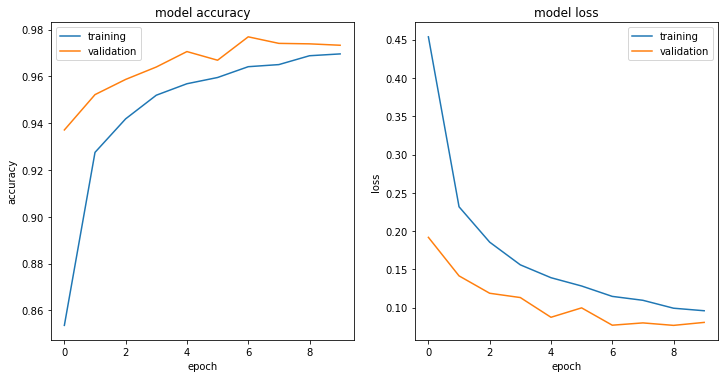

In [116]:
#Plotting the accuracy and loss graph for both the models
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 121)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 122)

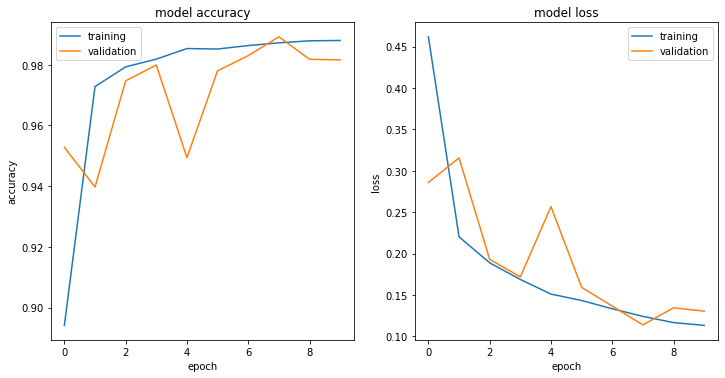

In [118]:
# Accuracy and loss for pretrained_model
plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history_two.history['acc'], history_two.history['val_acc'], 'accuracy', 121)
display_training_curves(history_two.history['loss'], history_two.history['val_loss'], 'loss', 122)

In [119]:
#Lets check the score for each model
model_one_score = pretrained_model.evaluate(X_test, y_test)
model_two_score = base_model.evaluate(X_test, y_test)
print('The loss and val accuracy for model one is {} and {}'.format(model_one_score[0], model_one_score[1]))
print('The loss and val accuracy for model one is {} and {}'.format(model_two_score[0], model_two_score[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0807 - acc: 0.9733
The loss and val accuracy for model one is 0.13048788905143738 and 0.9815999865531921
The loss and val accuracy for model one is 0.08074156939983368 and 0.9732999801635742


__Observations:__

- Both the models have trained well on this dataset. It is because the dataset is not quite complex, its a simple dataset.
- Our pretrained model has outperformed our base model by a small marginal difference. It means that any network with two to three Conv2D layers can achieve a higher accuracy on this dataset.


In [121]:
#lets also check the misclassificaion error
#We are simpaly going to check out how our model has performed in identifying the right label for each of the images present in 
#test dataset

def prdict_right_classes(model):
    predicted_classes = model.predict(X_test)
    prediction = np.argmax(predicted_classes, axis=-1)
    class_idx = np.argmax(y_test, axis=-1)

    #compare them wether they are rightly classifid or not
    correct = np.nonzero(prediction==class_idx)[0]
    incorrect = np.nonzero(prediction!=class_idx)[0]
    return correct.shape[0], incorrect.shape[0]

model_one_preds = prdict_right_classes(pretrained_model)
model_two_preds = prdict_right_classes(base_model)
print('Correct predictions: {} | Incorrect Predictions: {}'.format(model_one_preds[0], model_one_preds[1]))
print('Correct predictions: {} | Incorrect Predictions: {}'.format(model_two_preds[0], model_two_preds[1]))
print('Our Model has outperformed our baseline model by identifying {} classes as correctly.'.format(model_one_preds[0] - model_two_preds[0]))

Correct predictions: 9816 | Incorrect Predictions: 184
Correct predictions: 9733 | Incorrect Predictions: 267
Our Model has outperformed our baseline model by identifying 83 classes as correctly.


In [128]:
def prediction(model):
    predicted_classes = model.predict(X_test)
    prediction = np.argmax(predicted_classes, axis=-1)
    return prediction

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=-1)
model_one_preds = prediction(pretrained_model)
model_two_preds = prediction(base_model)

#Confusion matrix
pretrained_cm = confusion_matrix(y_true, model_one_preds)
base_cm = confusion_matrix(y_true, model_two_preds)

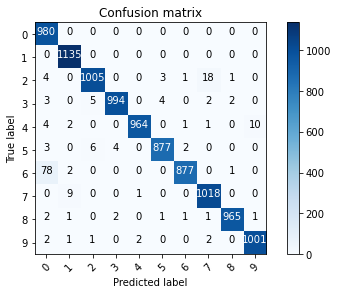

In [131]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(pretrained_cm,classes=range(NUM_CLASSES))

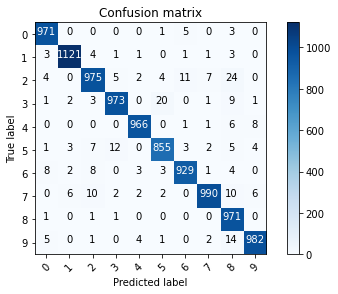

In [132]:
plot_confusion_matrix(base_cm,classes=range(NUM_CLASSES))

__Observations:__

- Our pretrained model has classified most of the images belong to label 6 as 0.
- Well this could be because of the reason that they are 0 and 6 written on a paper are king more similar to each other.
- Still our model has identified most of the images correctly as compare to our base model as there are so many images being misclassified by our base model
- In overall our model was able to perform better than the base model